# One system evaluated against multiple pairs of raters

In this notebook we show:

1. The evaluations for a single system can give very different results depending on the pair of human raters used to do the evaluations. 

2. Prmse gives stable results across different pairs of raters. 

In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt

import numpy as np

import itertools

from pathlib import Path

from rsmtool.utils.prmse import prmse_true
from rsmtool.analyzer import Analyzer

import json

%matplotlib inline

In [2]:
# let's define some settings and read the data
config = json.load(open('settings.json'))
fig_dir = Path('../paper_overleaf/figures')
df = pd.read_csv('../data/data.csv')
df_raters = pd.read_csv('../data/raters.csv')
df['system'] = df[config['sample_system']] # we use one sample system as defined in the config

In [3]:
def generate_rater_pairs_for_group(df_group, n_pairs):
    '''Generate a given number of random pairs of raters
    from the dataframe'''
    raters = df_group['rater_id']
    # get all possible rater pairs
    rater_pairs = ['{}+{}'.format(p[0], p[1]) for p in itertools.combinations(raters, 2)]
    np.random.seed(100)
    selected_pairs = np.random.choice(rater_pairs, n_pairs, replace=False)
    return selected_pairs

In [4]:
# randomly sample 50 pairs for each group
selected_pairs = df_raters.groupby('category').apply(generate_rater_pairs_for_group, n_pairs=50)
pair_dict = selected_pairs.to_dict()

In [5]:
# we create one long dataframe to speed up computation
data = []
for category in pair_dict:
    pairs = pair_dict[category]
    for p in pairs:
        (h1, h2) = p.split('+')
        df_p = pd.DataFrame({'pair': p, # pair id
                             'category': category, # category (quality of human agreement)
                              'h1': df[h1], # scores from rater 1
                              'h2': df[h2], # scores from rater 2
                              'system': df['system'], # system scores
                              'hh_corr': pearsonr(df[h1], df[h2])[0]}) # correlation between two humans
        data.append(df_p)
    df_long = pd.concat(data)

In [6]:
# compute average human score for each response
df_long['h_mean'] = (df_long['h1'] + df_long['h2'])/2

## Conventional metrics

Now let's compute various conventional metrics between the system score and the average human score for each pair of raters.

In [7]:
df_metrics = df_long.groupby('pair').apply(lambda x: Analyzer.metrics_helper(x['h_mean'],
                                                                             x['system']))

In [8]:
# now let's add rater category to this data
df_metrics_with_category = pd.merge(df_metrics, df_long[['pair', 'category', 'hh_corr']].drop_duplicates(), 
                                    left_index=True, right_on='pair')
len(df_metrics_with_category)

200

In [9]:
# we also add degradation since it's not computed by the metrics_helper
df_metrics_with_category['degradation'] = df_metrics_with_category['corr'] - df_metrics_with_category['hh_corr']

In [10]:
df_metrics_with_category.columns

Index(['kappa', 'wtkappa', 'exact_agr', 'adj_agr', 'SMD', 'corr', 'R2', 'RMSE',
       'sys_min', 'sys_max', 'sys_mean', 'sys_sd', 'h_min', 'h_max', 'h_mean',
       'h_sd', 'N', 'pair', 'category', 'hh_corr', 'degradation'],
      dtype='object')

In [11]:
# now let's rename the metrics to something more user friendly and 
# convert the dataframe to long format

rename_dict = {'corr': 'r',
              'wtkappa': "QWK"}

df_metrics_with_category = df_metrics_with_category.rename(columns=rename_dict)

df_metrics = df_metrics_with_category.melt(id_vars = ['hh_corr', 'category'],
                                           value_vars = ['QWK', 'r', 'R2', 'degradation'], 
                                           var_name='metrics',
                                           value_name='value')

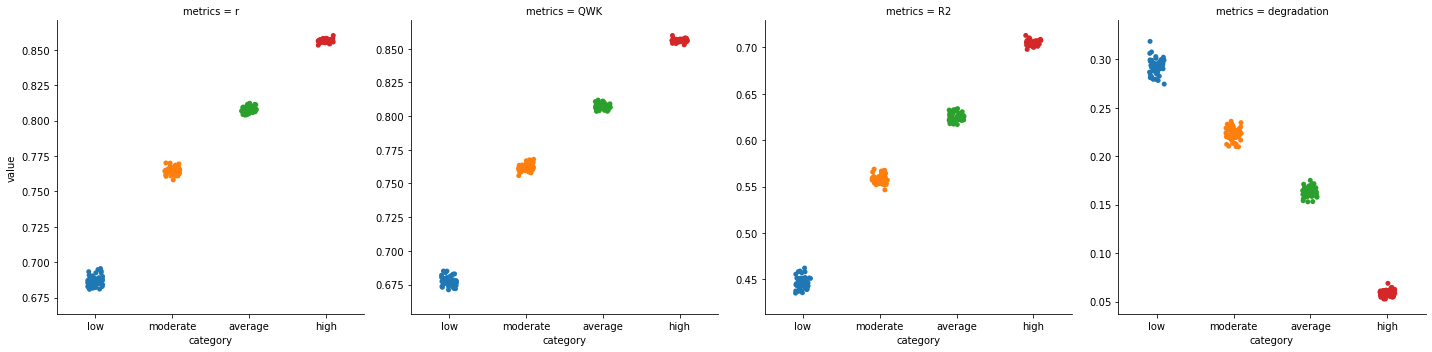

In [12]:
# generate first plot for the paper
g = sns.catplot(x='category', y='value', kind='strip',
                col="metrics", data=df_metrics,
                col_order=['r', 'QWK', 'R2', 'degradation'],
                order=config['rater_categories'],
                sharey=False)
g.savefig(fig_dir / 'pairs.png')

## PRMSE

Now we add PRMSE to the data and show how it helps keep the evaluation consistent across pairs. 

In [13]:
df_prmse = pd.DataFrame(df_long.groupby('pair').apply(lambda x: prmse_true(x['system'],
                                                              x[['h1', 'h2']])))
df_prmse.columns = ['value']
df_prmse['metrics'] = 'PRMSE'

In [14]:
# add rater category info
df_prmse_with_category = pd.merge(df_prmse, df_long[['pair', 'category', 'hh_corr']].drop_duplicates(), 
                                    left_index=True, right_on='pair')
len(df_prmse_with_category)

200

In [15]:
# combine this df with what we have for other metrics
df_all_metrics = pd.concat([df_metrics, df_prmse_with_category], sort=True)

In [16]:
# Print metrics statistics
df_all_metrics.groupby('metrics')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
metrics,,,,,,,,
PRMSE,200.0,0.794141,0.009431,0.758263,0.789628,0.794766,0.798374,0.832655
QWK,200.0,0.775653,0.066055,0.671059,0.738151,0.785800,0.822165,0.859862
R2,200.0,0.583875,0.095180,0.435272,0.525517,0.592963,0.650083,0.713022
degradation,200.0,0.184248,0.085928,0.052719,0.131924,0.192429,0.245628,0.318442
r,200.0,0.778818,0.062477,0.680857,0.742459,0.786964,0.822486,0.860097


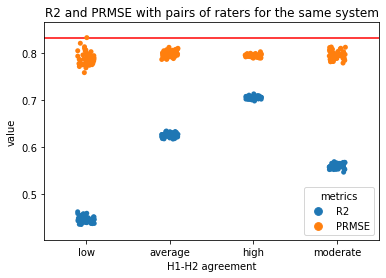

In [17]:
# Plot PRMSE and R2
ax = sns.stripplot(x='category', y='value', hue="metrics",
                  data=df_all_metrics[df_all_metrics['metrics'].isin(['R2', 'PRMSE'])])
# we also add a line for r2 with true score
true_r2 = r2_score(df['system'], df['true'])
ax.axhline(true_r2, color='red')
ax.set_title("R2 and PRMSE with pairs of raters for the same system")
ax.set_xlabel("H1-H2 agreement");
plt.savefig(fig_dir / 'prmse_single.png')